# 0. Overview

To parameterize a Markov State Model from data, we need:
- trajectories (time-ordered lists of structures),
- a function that maps structures to discrete states, and 
- a transition matrix (describing the probabilities of moving from one discrete state to another in a fixed amount of time).

What we hope to get out of a Markov State Model includes:
- An estimate of the stationary distribution
- A description of the longest-lived states of the system

The difficulties of estimating a transition matrix from discrete trajectories are largely settled. The major difficulties in practice arise in *discretization* -- selecting a function that maps structures to discrete state labels.

In this notebook, we will select a discretization function in three stages: (1) convert structures to feature vectors, (2) compute a linear transformation of these features that decorrelates slowly, mapping into a vector space where Euclidean distance is kinetically meaningful (using tICA), (3) discretizing this space using k-means clustering.

In [122]:
# import general libraries
import mdtraj as md
import msmbuilder
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
%matplotlib inline

# 1. Load trajectories

In [ ]:
# load trajectories
path_to_trajs = '../../../data/fah/10470/*.h5'
from glob import glob
filenames = glob(path_to_trajs)#[:50] # here looking at only the first 50
trajs = [md.load(f) for f in filenames]

In [123]:
sum([len(traj) for traj in trajs])

210555

In [128]:
lens = []
for traj in trajs:
    lens.append(len(traj))

In [129]:
sum(lens)

210555

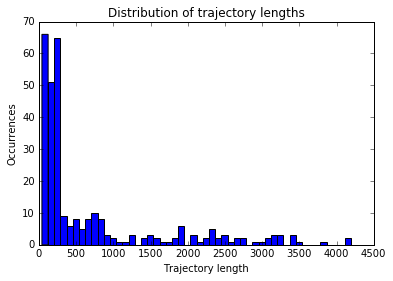

In [328]:
plt.hist(lens,bins=50);
plt.xlabel('Trajectory length')
plt.ylabel('Occurrences')
plt.title('Distribution of trajectory lengths')

# 2. Featurize

## 2.1. Inter-residue distances

In [4]:
def find_respairs_that_changed(trajs,
                               scheme = 'ca',    # or 'closest' or 'closest-heavy'
                               threshold = 0.4): # in nanometers
    '''
    
    Parameters
    ----------
    trajs : list of mdtraj.Trajectory objects
    
    scheme : 'ca' or 'closest' or 'closest-heavy'
    
    threshold : float
        contact threshold (nm)
    '''
    distances = []
    for traj in trajs:
        pairwise_distances,residue_pairs = md.compute_contacts(traj,scheme=scheme)
        distances.append(pairwise_distances)
    distances = np.vstack(distances)
    
    # identify contacts that change by counting how many times the distances were
    # greater than and less than the threshold
    num_times_greater_than = (distances>threshold).sum(0)
    num_times_less_than = (distances<threshold).sum(0)
    changed = (num_times_greater_than > 0) * (num_times_less_than > 0)
    print("Number of contacts that changed: {0}".format(changed.sum()))
    print("Total number of possible contacts: {0}".format(len(residue_pairs)))
    
    # now turn this bitmask into a list of relevant residue pairs
    respairs_that_changed = residue_pairs[changed]
    
    return respairs_that_changed

# examine a subset of the data to determine which residue pairs are crossing the threshold
scheme = 'closest'
threshold = 0.4
respairs_that_changed = find_respairs_that_changed([traj[::10] for traj in trajs[::5]],
                                                   scheme=scheme,
                                                   threshold=threshold)

Number of contacts that changed: 436
Total number of possible contacts: 13041


In [131]:
# featurize all frames using these residue pairs
X = []

for i,f in enumerate(filenames):
    print('{0}/{1}'.format(i,len(filenames)))
    traj = md.load(f)
    distances,_ = md.compute_contacts(traj,contacts=respairs_that_changed,scheme=scheme)

    X.append(distances)

0/301
1/301
2/301
3/301
4/301
5/301
6/301
7/301
8/301
9/301
10/301
11/301
12/301
13/301
14/301
15/301
16/301
17/301
18/301
19/301
20/301
21/301
22/301
23/301
24/301
25/301
26/301
27/301
28/301
29/301
30/301
31/301
32/301
33/301
34/301
35/301
36/301
37/301
38/301
39/301
40/301
41/301
42/301
43/301
44/301
45/301
46/301
47/301
48/301
49/301
50/301
51/301
52/301
53/301
54/301
55/301
56/301
57/301
58/301
59/301
60/301
61/301
62/301
63/301
64/301
65/301
66/301
67/301
68/301
69/301
70/301
71/301
72/301
73/301
74/301
75/301
76/301
77/301
78/301
79/301
80/301
81/301
82/301
83/301
84/301
85/301
86/301
87/301
88/301
89/301
90/301
91/301
92/301
93/301
94/301
95/301
96/301
97/301
98/301
99/301
100/301
101/301
102/301
103/301
104/301
105/301
106/301
107/301
108/301
109/301
110/301
111/301
112/301
113/301
114/301
115/301
116/301
117/301
118/301
119/301
120/301
121/301
122/301
123/301
124/301
125/301
126/301
127/301
128/301
129/301
130/301
131/301
132/301
133/301
134/301
135/301
136/301
137/301
138/30

## 2.2. Dihedrals

In [132]:
# also featurize using dihedrals

from msmbuilder.featurizer import DihedralFeaturizer
dih_model = DihedralFeaturizer()
X_dih = dih_model.fit_transform(trajs)

## 2.3. Heavy-atom RMSD

In [329]:
# also featurize using heavy-atom RMSD to a random subset of frames
k = 150

from msmbuilder.featurizer import RMSDFeaturizer
npr.seed(0)
inds = []
for i in range(len(dtrajs)):
    for j in range(len(dtrajs[i])):
        inds.append((i,j))
inds = np.array(inds)
npr.shuffle(inds)
inds = inds[:k]

frames = []
for i,j in inds:
    frames.append(trajs[i][j])
traj = frames[0].join(frames[1:])
del(frames)
traj

<mdtraj.Trajectory with 150 frames, 2636 atoms, 164 residues, and unitcells at 0x16c6bd710>

In [172]:
top = traj.topology
atom_indices = top.select('mass>12')[::5]
len(atom_indices)

262

In [175]:
%%time
rmsd_ = RMSDFeaturizer(traj,atom_indices)
X_rmsd = []
for i in range(len(trajs)):
    print(i)
    X_rmsd.append(rmsd_.fit_transform([trajs[i]])[0])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
X_dih[1].shape

# 3. Kinetic distance learning

## 3.1. Apply individually to inter-residue distance features

In [133]:
# tICA
import pyemma
tica = pyemma.coordinates.tica(X,lag=50,kinetic_map=True)
Y = tica.get_output()
print("Dimensionality after tICA, retaining enough eigenvectors to explain 0.95 of kinetic variation: {0}".format(np.vstack(Y).shape[1]))

calculate covariances:  94% (284/301) [##########################  ] eta 00:01 |11-02-16 20:55:51 pyemma.coordinates.transform.tica.TICA[15] WARNING  Had to skip 17 trajectories for being too short. Their indexes are in self._skipped_trajs.
getting output of TICA: 100% (301/301) [###########################] eta 00:01 /Dimensionality after tICA, retaining enough eigenvectors to explain 0.95 of kinetic variation: 58


In [134]:
inds = np.argmax(tica.feature_TIC_correlation,axis=1)
corrs = np.abs(tica.feature_TIC_correlation[inds,0])

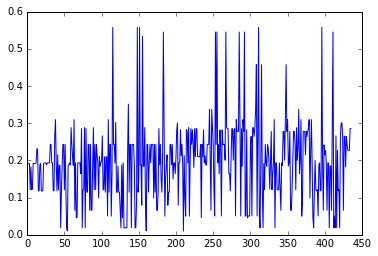

In [135]:
plt.plot(corrs)

In [136]:
corrs[0]

0.19141578177290791

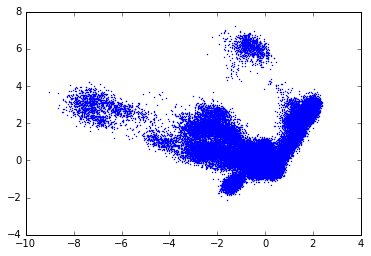

In [137]:
for y in Y:
    plt.scatter(y[:,0],y[:,1],linewidths=0,s=2)

## 3.2. Apply individually to dihedral angle features

In [138]:
tica_dih = pyemma.coordinates.tica(X_dih,lag=50,kinetic_map=True)
Y_dih = tica_dih.get_output()
print("Dimensionality after tICA, retaining enough eigenvectors to explain 0.95 of kinetic variation: {0}".format(np.vstack(Y_dih).shape[1]))

calculate covariances:  94% (284/301) [##########################  ] eta 00:01 -11-02-16 20:56:17 pyemma.coordinates.transform.tica.TICA[16] WARNING  Had to skip 17 trajectories for being too short. Their indexes are in self._skipped_trajs.
getting output of TICA: 100% (301/301) [###########################] eta 00:01 \Dimensionality after tICA, retaining enough eigenvectors to explain 0.95 of kinetic variation: 76


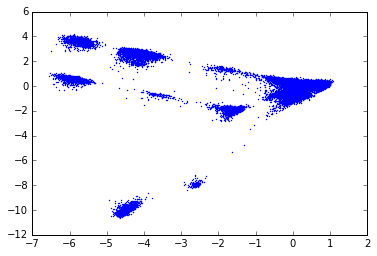

In [139]:
for y in Y_dih:
    plt.scatter(y[:,0],y[:,1],linewidths=0,s=2)

## 3.3. Apply individually to RMSD features

In [176]:
tica_rmsd = pyemma.coordinates.tica(X_rmsd,lag=50,kinetic_map=True)
Y_rmsd = tica_rmsd.get_output()
print("Dimensionality after tICA, retaining enough eigenvectors to explain 0.95 of kinetic variation: {0}".format(np.vstack(Y_rmsd).shape[1]))

calculate covariances:  94% (284/301) [##########################  ] eta 00:01 |11-02-16 21:27:58 pyemma.coordinates.transform.tica.TICA[19] WARNING  Had to skip 17 trajectories for being too short. Their indexes are in self._skipped_trajs.
getting output of TICA: 100% (301/301) [###########################] eta 00:01 /Dimensionality after tICA, retaining enough eigenvectors to explain 0.95 of kinetic variation: 33


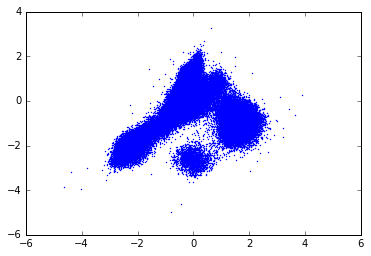

In [177]:
for y in Y_rmsd:
    plt.scatter(y[:,0],y[:,1],linewidths=0,s=2)

## 3.4. Apply to concatenated feature vectors, containing all of the above!

In [178]:
feature_sets = [X,X_dih,X_rmsd]
X_combined = [np.hstack([x[i] for x in feature_sets]) for i in range(len(feature_sets[0]))]
X_combined[0].shape

(160, 1238)

In [179]:
tica_combined = pyemma.coordinates.tica(X_combined,lag=50,kinetic_map=True)
Y_combined = tica_combined.get_output()
print("Dimensionality after tICA, retaining enough eigenvectors to explain 0.95 of kinetic variation: {0}".format(np.vstack(Y_combined).shape[1]))

calculate covariances:  94% (284/301) [##########################  ] eta 00:03 -11-02-16 21:28:58 pyemma.coordinates.transform.tica.TICA[20] WARNING  Had to skip 17 trajectories for being too short. Their indexes are in self._skipped_trajs.
getting output of TICA: 100% (301/301) [###########################] eta 00:01 \Dimensionality after tICA, retaining enough eigenvectors to explain 0.95 of kinetic variation: 330


In [182]:
del(X_combined)

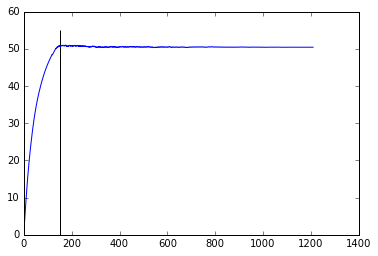

In [185]:
plt.plot(np.cumsum(tica_combined.eigenvalues))
plt.vlines(150,0,55)

In [186]:
# actually, I think it probably makes sense to discard starting when this goes noisy / negative?
Y_ = [y[:,:150] for y in Y_combined]

In [187]:
del(Y_combined)

In [188]:
inds = np.argmax(tica_combined.feature_TIC_correlation,axis=1)
corrs = np.abs(tica_combined.feature_TIC_correlation[inds,0])
corrs[0]

0.015714309955385985

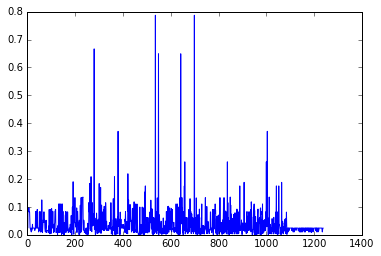

In [189]:
plt.plot(corrs)

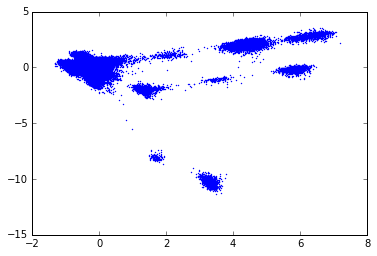

In [192]:
for y in Y_:
    plt.scatter(y[:,0],y[:,1],linewidths=0,s=2)

# 4. Clustering

In [193]:
# cluster using combined feature-space kinetic distance, with different numbers of target
# clusters

k_means = pyemma.coordinates.cluster_mini_batch_kmeans(Y_,k=1000,max_iter=1000)

kmeans iterations:   7% (  72/1000) [##                          ] eta 3:07:06 \11-02-16 21:46:51 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[21] INFO     Cluster centers converged after 73 steps.
kmeans iterations: 100% (1000/1000) [##############################] eta 00:00 -

In [230]:
k_means_500 = pyemma.coordinates.cluster_mini_batch_kmeans(Y_,k=500,max_iter=1000)
k_means_100 = pyemma.coordinates.cluster_mini_batch_kmeans(Y_,k=100,max_iter=1000)
k_means_50 = pyemma.coordinates.cluster_mini_batch_kmeans(Y_,k=50,max_iter=1000)

kmeans iterations:  14% ( 140/1000) [###                         ] eta 1:30:46 -11-02-16 22:51:48 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[24] INFO     Cluster centers converged after 141 steps.
kmeans iterations:  20% ( 207/1000) [######                        ] eta 17:27 |11-02-16 22:56:26 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[25] INFO     Cluster centers converged after 208 steps.
kmeans iterations: 100% (1000/1000) [##############################] eta 00:01 /11-02-16 23:08:48 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[26] INFO     Algorithm did not reach convergence criterion of 1e-05 in 1000 iterations. Consider increasing max_iter.
kmeans iterations: 100% (1000/1000) [##############################] eta 00:01 \

In [231]:
# reshape into a list of numpy arrays
dtrajs_500 = [np.array(dtraj)[:,0] for dtraj in k_means_500.get_output()]

getting output of MiniBatchKmeansClustering: 100% (301/301) [######] eta 00:01 |

# 5. MSM estimation and validation

## 5.1. Inspect implied timescales plots to identify Markovian lag-time

In [232]:
# select lag-time for MSM estimation:
# we're looking for the earliest lag-time where these curves flatten out
its = pyemma.msm.its(dtrajs_500,nits=10)

estimating MaximumLikelihoodMSM: 100% (14/14) [####################] eta 00:09 \

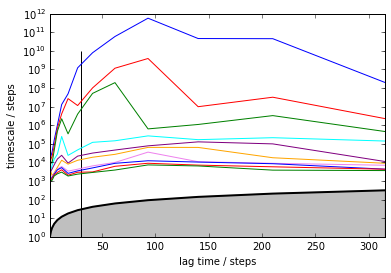

In [233]:
pyemma.plots.plot_implied_timescales(its)

# eye-balling it, maybe around 50?
lag_time=30
plt.vlines(lag_time,0,1e10)

estimating MaximumLikelihoodMSM: 100% (14/14) [####################] eta 00:00 \

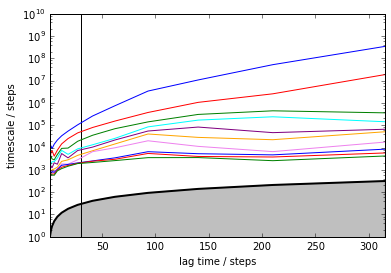

In [234]:
dtrajs_100 = [np.array(dtraj)[:,0] for dtraj in k_means_100.get_output()]
its_100 = pyemma.msm.its(dtrajs_100,nits=10)
pyemma.plots.plot_implied_timescales(its_100)
plt.vlines(lag_time,0,1e10)

## 5.2. Estimate MSM

In [235]:
# estimate an MSM using this lag-time
msm = pyemma.msm.estimate_markov_model(dtrajs_100,lag_time)

## 5.3. Inspect MSM

### 5.3.1. Metastability

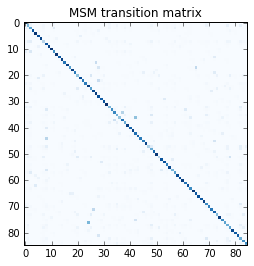

In [331]:
plt.imshow(msm.P,interpolation='none',cmap='Blues')
plt.title('MSM transition matrix')

In [236]:
# metastability
np.trace(msm.P)

63.136099121248392

In [237]:
msm.P.shape

(85, 85)

In [238]:
# fractional metastability (approaches 1.0 as process becomes more perfectly metastable)
np.trace(msm.P)/len(msm.P)

0.74277763672056929

### 5.3.2. Implied timescales

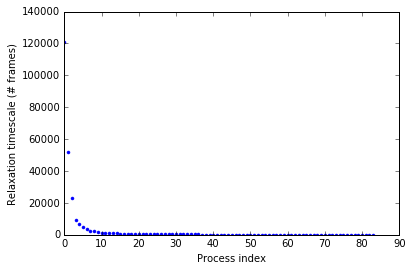

In [330]:
plt.plot(msm.timescales(),'.')
plt.xlabel('Process index')
plt.ylabel('Relaxation timescale (# frames)')

In [255]:
mb_msm = msmbuilder.msm.MarkovStateModel(lag_time,ergodic_cutoff=1.0)
mb_msm.fit([dtraj[50:] for dtraj in dtrajs_100 if len(dtraj)>50])

MSM contains 42 strongly connected components above weight=1.00. Component 10 selected, with population 82.298095%


MarkovStateModel(ergodic_cutoff=1.0, lag_time=30, n_timescales=None,
         prior_counts=0, reversible_type='mle', sliding_window=True,
         verbose=True)

In [256]:
mb_msm.transmat_.shape

(49, 49)

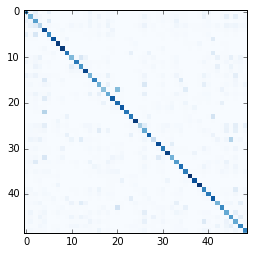

In [259]:
plt.imshow(mb_msm.transmat_,interpolation='none',cmap='Blues')
plt.colorbar()

In [257]:
mb_msm.timescales_

array([ 2386.6973343 ,  2124.15400988,   868.50315148,   542.23366376,
         461.61825623,   342.42937894,   329.21383234,   306.08793137,
         291.13444798,   273.70417338,   233.21987947,   183.11442497,
         166.66868366,   150.83480461,   132.35420308,   126.91098666,
         111.48451148,   111.10446896,   107.4372967 ,    86.3657304 ,
          82.02177768,    80.81463876,    77.48065404,    75.53640897,
          72.17906818,    70.85761444,    65.79686366,    64.96976376,
          63.23097398,    60.88176288,    55.81313318,    54.11290886,
          52.46517744,    48.075868  ,    47.36537865,    39.56568796,
          38.52040917,    37.04081281,    35.27445773,    33.39613074,
          31.86687831,    30.49598232,    29.62247372,    27.51913611,
          27.43795625,    25.93188985,    22.54373718,    16.84327271])

In [258]:
np.trace(mb_msm.transmat_),np.trace(mb_msm.transmat_)/len(mb_msm.transmat_)

(32.405690405047153, 0.66134062051116638)

# 6. Coarse-grain / identify metastable macrostates

In [332]:
# given a metastability threshold, choose number of metastable states
from simtk import unit as u
integration_timestep = 2.0 * u.femtosecond
time_per_frame = 1000 * integration_timestep # this is probably wrong
time_per_frame.value_in_unit(u.picosecond)

metastability_threshold = 2 * u.nanosecond

threshold_in_frames = metastability_threshold/time_per_frame
threshold_in_frames

999.9999999999999

In [344]:
n_macro = sum(msm.timescales()>5000)
n_macro

6

In [345]:
#coarse-grain!

In [346]:
# coarse-grain with an HMM

In [347]:
hmm = pyemma.msm.estimate_hidden_markov_model([dtraj for dtraj in dtrajs if len(dtraj)>lag_time],nstates=n_macro,lag=lag_time)

12-02-16 11:32:08 pyemma.msm.estimators.maximum_likelihood_hmsm.MaximumLikelihoodHMSM[33] WARNING  Requested coarse-grained model with 6 metastable states at lag=30.The ratio of relaxation timescales between 6 and 7 states is only 1.78197710828 while we recommend at least 2.  It is possible that the resulting HMM is inaccurate. Handle with caution.


In [348]:
np.trace(hmm.P)

5.0055362889032473

In [349]:
np.trace(hmm.P)/len(hmm.P)

0.83425604815054122

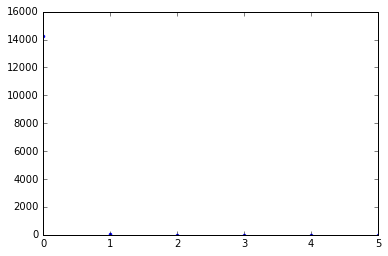

In [350]:
hmm_lifetimes = 1/(1-np.diag(hmm.P))
plt.plot(np.sort(hmm_lifetimes)[::-1],'.')

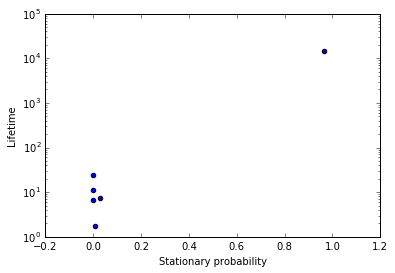

In [352]:
plt.scatter(hmm.stationary_distribution,hmm_lifetimes)
plt.xlabel('Stationary probability')
plt.ylabel('Lifetime')

#plt.xscale('log')
plt.yscale('log')

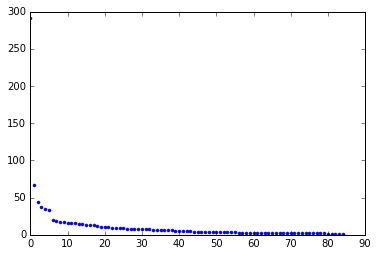

In [353]:
msm_lifetimes = 1/(1-np.diag(msm.P))
plt.plot(np.sort(msm_lifetimes)[::-1],'.')

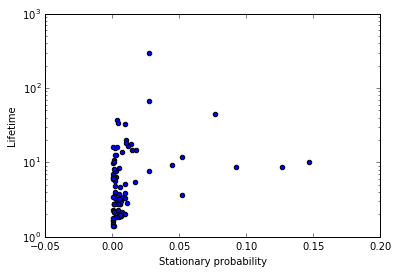

In [354]:
plt.scatter(msm.stationary_distribution,msm_lifetimes)
plt.xlabel('Stationary probability')
plt.ylabel('Lifetime')

#plt.xscale('log')
plt.yscale('log')

In [363]:
mb_msm.n_states_

49

In [366]:
# coarse-grain with PCCA

from msmbuilder import lumping

pcca = lumping.PCCA(n_macro)
pcca = pcca.from_msm(mb_msm,n_macro)

In [ ]:
# to-do: analyze

In [ ]:
# to-do: coarse-grain with PCCA+
from msmbuilder.msm import PCCAPlus

In [ ]:
# to-do: examine structures within clusters

# can i plot exemplar structures here?
# use one of the packages for in-browser visualization developed by @rmcgibbo or @cxhr ?